# Cats vs Dogs

Kaggle Competition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

![Alt text](title.jpeg)

In [173]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [246]:
TRAIN_DIR = '../datasets/cats_vs_dogs/train/'
TEST_DIR = '../datasets/cats_vs_dogs/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

TRAIN_SAMPLES = 1000 # all are 25 000
TEST_SAMPLES = 100 # all are 12 500

DOG_NAME_PATTERN = "dog"
CAT_NAME_PATTERN = "cat"
LABELS = {DOG_NAME_PATTERN: 1, CAT_NAME_PATTERN: 0}


def get_matching_files(dir_path, substring=None):
    matching_files = list()
    for filename in os.listdir(dir_path):
        abs_path = os.path.join(dir_path, filename)
        if substring:
            if substring in filename:
                matching_files.append(abs_path)
        else:
            matching_files.append(abs_path)
    return matching_files


def load_image_and_resize(file_path, res=None):
    rows = res if res else ROWS
    cols = res if res else COLS
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (rows, cols), interpolation=cv2.INTER_CUBIC)


def load_images(image_files, res=None):
    count = len(image_files)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for index, image_file in enumerate(image_files):
        image = load_image_and_resize(image_file)
        data[index] = image.T
        if index % 250 == 0:
            print('Loaded {} of {} images.'.format(index, count))
    return data


def load_labels(files):
    labels = []
    for filename in files:
        for name, value in LABELS.items():
            if name in os.path.basename(filename):
                labels.append(value)
    return pd.DataFrame(labels)


def get_train_data():
    all_train_samples = len(os.listdir(TRAIN_DIR))
    train = list()
    if TRAIN_SAMPLES == all_train_samples:
        train = get_matching_files(TRAIN_DIR)
    else:
        train_dogs = get_matching_files(TRAIN_DIR, DOG_NAME_PATTERN)
        train_cats = get_matching_files(TRAIN_DIR, CAT_NAME_PATTERN)
        train = train_dogs[:(TRAIN_SAMPLES // 2)] + train_cats[:(TRAIN_SAMPLES // 2)]
    random.shuffle(train)
    return train


def prepare_data():
    print("Loading TRAIN data...")
    train_files = get_train_data()
    X_train = load_images(train_files)
    y_train = load_labels(train_files)

    print("\nLoading TEST data...")
    test = load_images(get_matching_files(TEST_DIR)[:TEST_SAMPLES])

    return X_train, y_train, test


X_train, y_train, test = prepare_data()

print("\nTrain shape: {}".format(X_train.shape))
print("Test shape: {}".format(test.shape))

Loading TRAIN data...
Loaded 0 of 1000 images.
Loaded 250 of 1000 images.
Loaded 500 of 1000 images.
Loaded 750 of 1000 images.

Loading TEST data...
Loaded 0 of 100 images.

Train shape: (1000, 3, 64, 64)
Test shape: (100, 3, 64, 64)


In [171]:
def show_cats_and_dogs(start_idx, end_idx, res=512):
    train_dogs = get_matching_files(TRAIN_DIR, DOG_NAME_PATTERN)
    train_cats = get_matching_files(TRAIN_DIR, CAT_NAME_PATTERN)
    idx = start_idx
    while idx < end_idx:
        dog1, dog2 = load_image_and_resize(train_dogs[idx], res=res), load_image_and_resize(train_dogs[idx + 1], res=res)
        cat1, cat2 = load_image_and_resize(train_cats[idx], res=res), load_image_and_resize(train_cats[idx + 1], res=res)
        idx += 2
        pair1 = np.concatenate((cat1, dog1), axis=1)
        pair2 = np.concatenate((cat2, dog2), axis=1)
        fig = plt.figure(figsize=(32, 32))
        ax1 = fig.add_subplot(221)
        ax1.imshow(pair1)
        ax2 = fig.add_subplot(222)
        ax2.imshow(pair2)
        plt.show()

## Dataset

* Имаме train set с 25 000 картинки на кучета и котки
* И test set с 12 500 картинки за идентифициране

Нека видим какво имаме в train set-a:

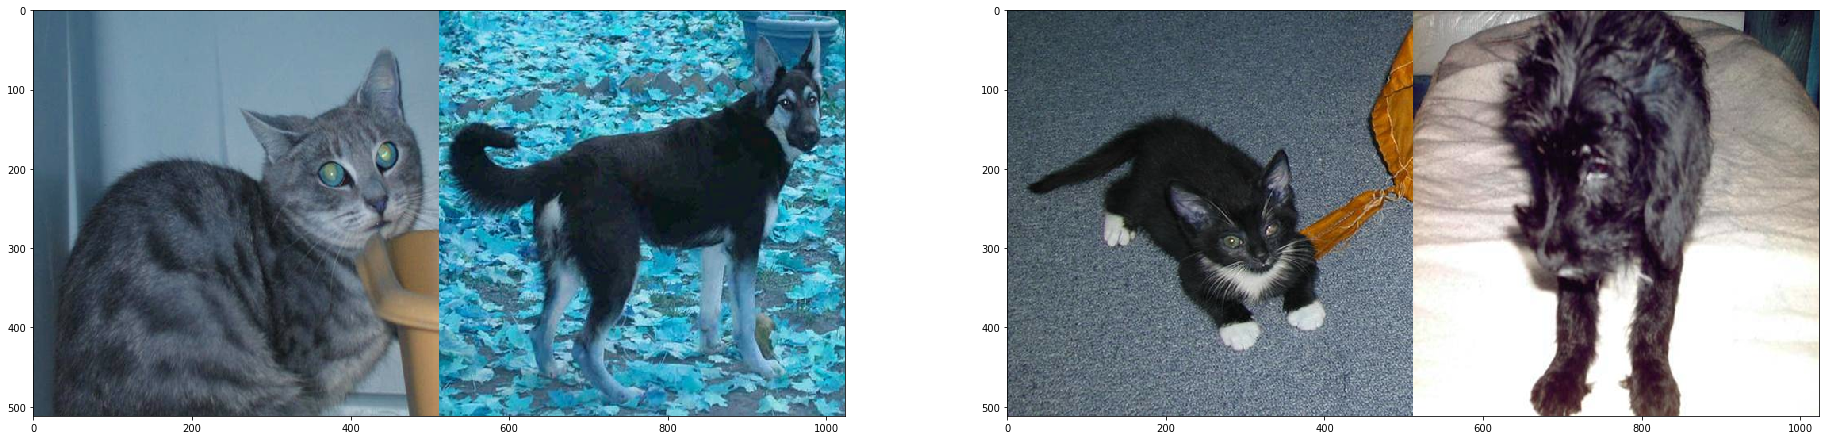

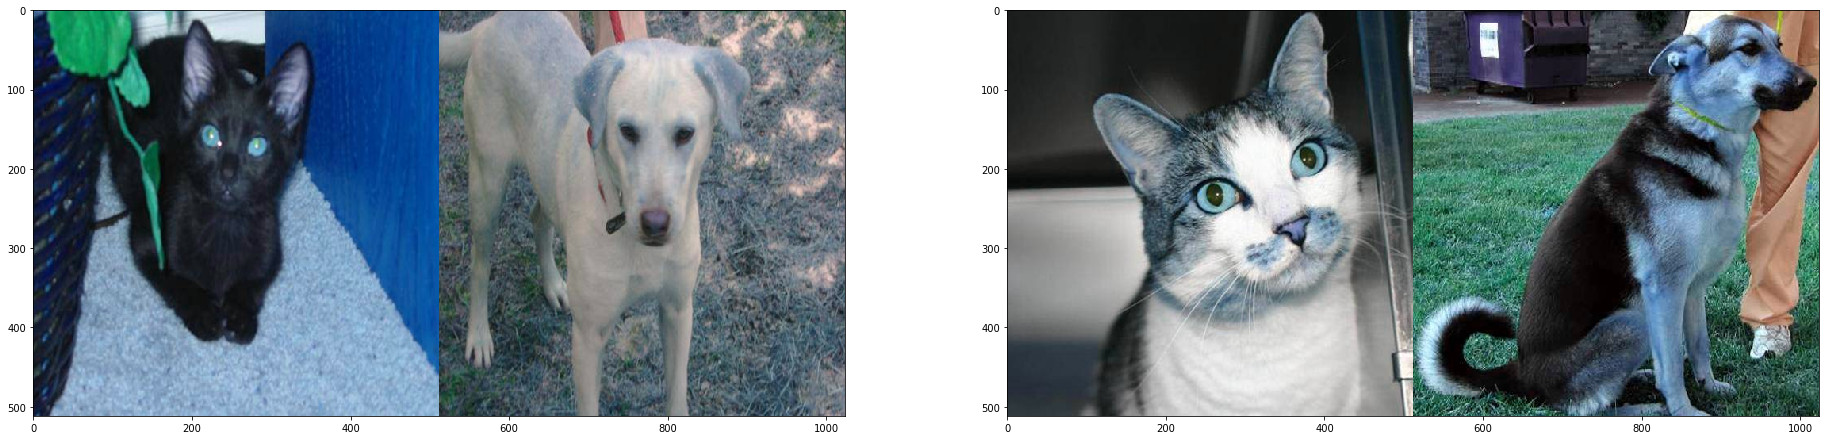

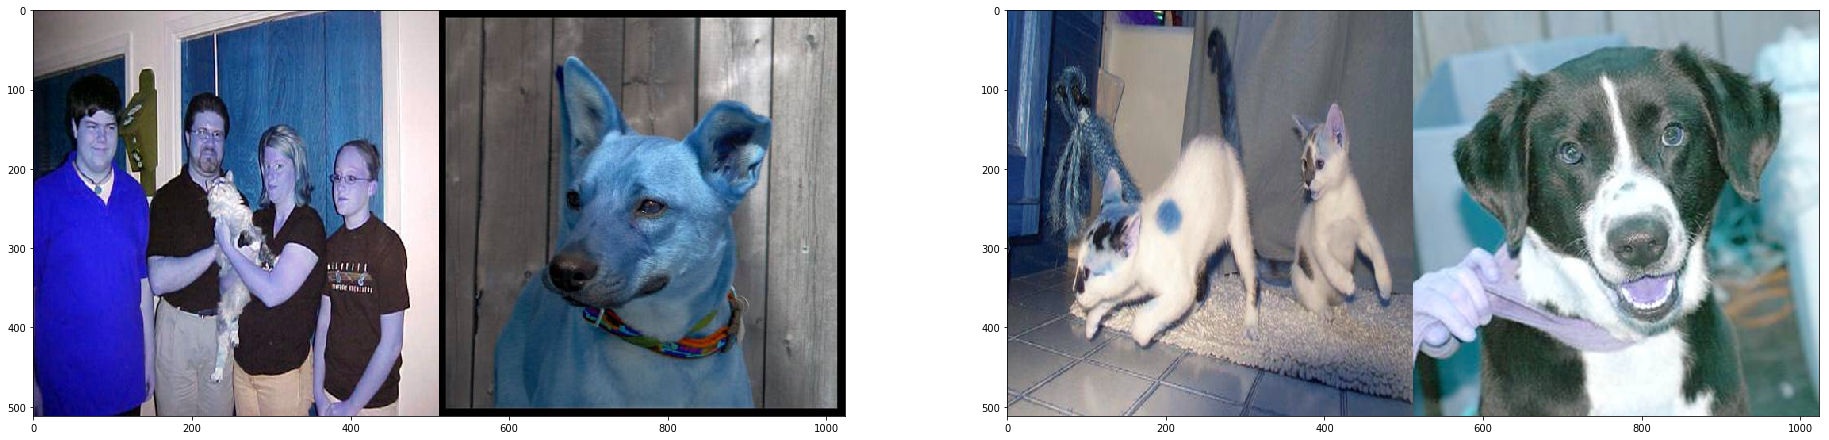

In [172]:
show_cats_and_dogs(0, 6)

## Подход

* Ще използваме convolutional neural network (конвулационна невронна мрежа?) с keras и tensorflow backend
* С optimizer = RMSprop
* Output layer-a е sigmoid, защото имаме binary crossentropy

Нека видим и base модела:

In [262]:
optimizer = RMSprop(lr=0.0001)
objective = 'binary_crossentropy'
metrics = ['accuracy']


def catdog():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    
    for i in range(6, 9):
        model.add(Conv2D(2**i, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(2**i, (3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=metrics)
    return model

In [250]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_344 (Conv2D)          (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_345 (Conv2D)          (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 3, 32, 16)         0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 3, 32, 16)         0         
_________________________________________________________________
conv2d_346 (Conv2D)          (None, 3, 32, 64)         9280      
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 3, 16, 32)         0         
__________

## Train

* 1500 train samples & 500 validation samples
* 20 епохи на CPU
* EarlyStopping за да не overfit-ва

~ 50-60% точност:

In [263]:
model = catdog()
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
model.fit(X_train, y_train, epochs=10, validation_split=0.25, shuffle=True, callbacks=[early_stop])

Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 6s 7ms/step - loss: 1.2257 - acc: 0.5053 - val_loss: 0.7341 - val_acc: 0.4520
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 0.8017 - acc: 0.4973 - val_loss: 0.6913 - val_acc: 0.5400
Epoch 3/10
750/750 [==============================] - 4s 6ms/step - loss: 0.7453 - acc: 0.5280 - val_loss: 0.8077 - val_acc: 0.4560
Epoch 4/10
750/750 [==============================] - 4s 6ms/step - loss: 0.7517 - acc: 0.5280 - val_loss: 0.6986 - val_acc: 0.5680
Epoch 5/10
750/750 [==============================] - 4s 5ms/step - loss: 0.7465 - acc: 0.5293 - val_loss: 0.6810 - val_acc: 0.5680
Epoch 6/10
750/750 [==============================] - 4s 6ms/step - loss: 0.7388 - acc: 0.5187 - val_loss: 0.7170 - val_acc: 0.4600
Epoch 7/10
750/750 [==============================] - 5s 7ms/step - loss: 0.7398 - acc: 0.5147 - val_loss: 0.6967 - val_acc: 0.4560
Epoch 8/10
750/750 [==========

Да видим какво ще каже моделът и за тестовите данни:

I am 54.37% sure this is a Dog


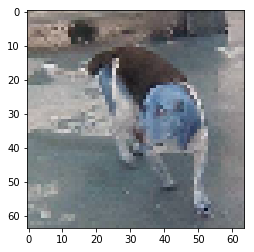

I am 50.39% sure this is a Dog


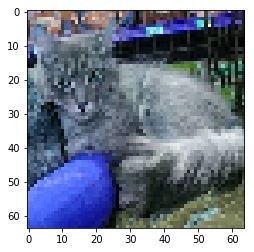

I am 53.18% sure this is a Cat


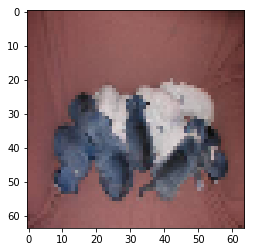

I am 50.02% sure this is a Dog


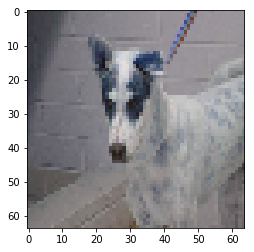

I am 51.67% sure this is a Dog


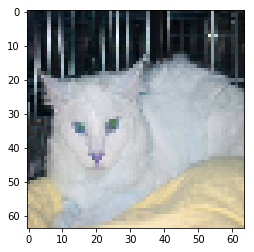

I am 51.41% sure this is a Dog


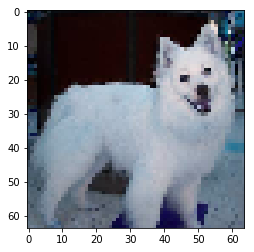

I am 54.33% sure this is a Cat


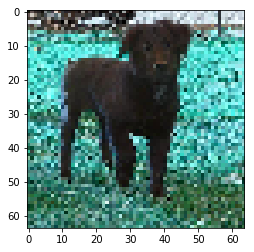

I am 51.86% sure this is a Cat


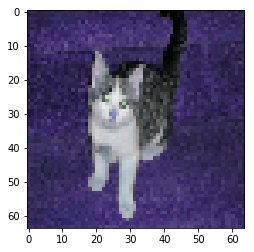

I am 51.12% sure this is a Dog


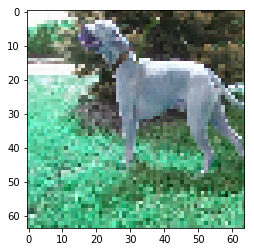

I am 51.49% sure this is a Cat


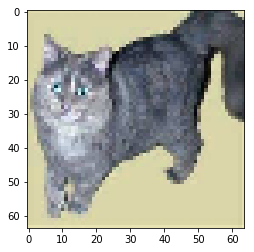

In [265]:
predictions = model.predict(test, verbose=0)
for i in range(0, 10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()